# Time Series Prediction with Lotka Volterra Equation Inspired Deep Learning ($LVPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-12 17:28:36

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Pretraining

_Lotka Volterra Intermittency_

The `lotka_volterra_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Lotka Volterra Equations

In [3]:
data = np.genfromtxt('datasets/lotka_volterra_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

215.48740705
1        -1.540163e-03
2        -1.523369e-03
3        -1.506756e-03
4        -1.490327e-03
5        -1.474074e-03
              ...     
139867   -1.591086e-35
139868   -1.573887e-35
139869   -1.556877e-35
139870   -1.540049e-35
139871   -1.523404e-35
Name: 1, Length: 139871, dtype: float64
2         2.399184e-06
3         2.373265e-06
4         2.346939e-06
5         2.321837e-06
6         2.296327e-06
              ...     
139867    2.483673e-38
139868    2.456939e-38
139869    2.430082e-38
139870    2.403980e-38
139871    2.377878e-38
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_EL NINO_

In [5]:
data = pd.read_csv("datasets/elnino.csv")
training_set = data.iloc[:, 1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


In [6]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0        -1.540163e-03
1        -1.523369e-03
2        -1.506756e-03
3        -1.490327e-03
4        -1.474074e-03
              ...     
139866   -1.591086e-35
139867   -1.573887e-35
139868   -1.556877e-35
139869   -1.540049e-35
139870   -1.523404e-35
Name: 1, Length: 139871, dtype: float64
0         2.399184e-06
1         2.373265e-06
2         2.346939e-06
3         2.321837e-06
4         2.296327e-06
              ...     
139865    2.483673e-38
139866    2.456939e-38
139867    2.430082e-38
139868    2.403980e-38
139869    2.377878e-38
Name: 1, Length: 139870, dtype: float64


In [7]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the Data into Supervised Learning

In [8]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        23.4       23.4       24.2       24.4       25.1       25.8   
11        23.4       24.2       24.4       25.1       25.8       25.9   
12        24.2       24.4       25.1       25.8       25.9       26.1   
13        24.4       25.1       25.8       25.9       26.1       26.1   
14        25.1       25.8       25.9       26.1       26.1       26.7   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10       25.9       26.1       26.1       26.7     26.1 -0.001380  0.000002  
11       26.1       26.1       26.7       26.1     26.1 -0.001365  0.000002  
12       26.1       26.7       26.1       26.1     25.7 -0.001350  0.000002  
13       26.7       26.1       26.1       25.7     25.6 -0.001336  0.000002  
14       26.1       26.1       25.7       25.6     25.1 -0.001321  0.000002  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [9]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1298, 1, 10) (1298, 3) (325, 1, 10) (325, 3)


## Model ($LVPINN$)

In [10]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
21/21 - 18s - loss: 0.3025 - val_loss: 0.2204 - 18s/epoch - 855ms/step
Epoch 2/500
21/21 - 0s - loss: 0.1487 - val_loss: 0.0892 - 208ms/epoch - 10ms/step
Epoch 3/500
21/21 - 0s - loss: 0.0758 - val_loss: 0.0493 - 217ms/epoch - 10ms/step
Epoch 4/500
21/21 - 0s - loss: 0.0649 - val_loss: 0.0430 - 216ms/epoch - 10ms/step
Epoch 5/500
21/21 - 0s - loss: 0.0614 - val_loss: 0.0391 - 205ms/epoch - 10ms/step
Epoch 6/500
21/21 - 0s - loss: 0.0568 - val_loss: 0.0355 - 390ms/epoch - 19ms/step
Epoch 7/500
21/21 - 0s - loss: 0.0531 - val_loss: 0.0320 - 310ms/epoch - 15ms/step
Epoch 8/500
21/21 - 0s - loss: 0.0498 - val_loss: 0.0288 - 293ms/epoch - 14ms/step
Epoch 9/500
21/21 - 0s - loss: 0.0467 - val_loss: 0.0259 - 237ms/epoch - 11ms/step
Epoch 10/500
21/21 - 0s - loss: 0.0439 - val_loss: 0.0232 - 223ms/epoch - 11ms/step
Epoch 11/500
21/21 - 0s - loss: 0.0413 - val_loss: 0.0207 - 206ms/epoch - 10ms/step
Epoch 12/500
21/21 - 0s - loss: 0.0390 - val_loss: 0.0185 - 215ms/epoch - 10ms/step
E

## Metrics ($LVPINN$)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

11/11 [==============================] - 5s 5ms/step
(325, 3)
(325, 10)
Test RMSE: 0.431
Test MAE: 0.334


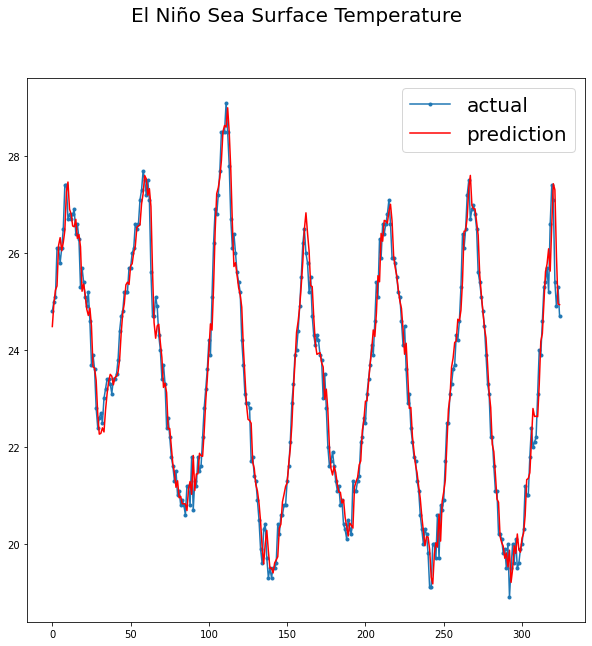

In [12]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()